# Lossless Compression of Images using Lempel-Ziv-Welch (LZW)

This code is provided as supplementary material of the lecture Quellencodierung (QC).<br>

This code illustrates
* The use of the LZW algorithm for encoding and decoding strings
* The application of the LZW algorithm to compress an image (similar to GIF)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
def LZW_encode(initial_symbols, x):
    codebook = {tuple([ value ]):idx for  idx,value in enumerate(initial_symbols)}   
    
    # output
    retval = []
    
    omega = tuple([ x[0] ])
    l = 1
    while l < len(x):
        omega_prime = omega + tuple([ x[l] ])
        if omega_prime in codebook:
            # if in codebook, update omega
            omega = omega_prime
        else:
            # output omega and add omega_prime to codebook
            retval.append( codebook[omega] )
            codebook[ omega_prime ] = max(codebook.values()) + 1            
            
            omega = tuple([ x[l] ])
        
        l = l+1
    retval.append( codebook[omega] )     
    
    return retval, codebook
            
# Example from the lecture    
rv,cb = LZW_encode(['a','b','c'], np.fromiter('ababcbababaaaaaa', (np.str,1)))
print(np.array(rv))
print(cb)

[ 0  1  3  2  4  7  0  9 10]
{('a',): 0, ('b',): 1, ('c',): 2, ('a', 'b'): 3, ('b', 'a'): 4, ('a', 'b', 'c'): 5, ('c', 'b'): 6, ('b', 'a', 'b'): 7, ('b', 'a', 'b', 'a'): 8, ('a', 'a'): 9, ('a', 'a', 'a'): 10}


In [14]:
def LZW_decode(initial_symbols, y):
    # use reverse codebook for decoding, use lists instead of tuples to directly generate output
    # be careful to properly copy the lists
    codebook = {idx: [ value ] for idx,value in enumerate(initial_symbols)}
    
    # first output symbol is obvious
    retval = codebook[ y[0] ].copy()
    
    potential_entry = codebook[ y[0] ].copy()
    
    l = 1
    while l < len(y):        
        if y[l] in codebook:            
            # append first character of output and add to codebook
            potential_entry.append( codebook[ y[l] ][0] )
        else:
            potential_entry.append( potential_entry[0] )   
            
        codebook[max(codebook.keys())+1] = potential_entry.copy()                                
        retval += codebook[ y[l] ].copy()
        potential_entry = codebook[ y[l] ].copy()
        l += 1    
    return retval

rv = LZW_decode(['a','b','c'], [0,1,3,2,4,7,0,9,10])
print(rv)

['a', 'b', 'a', 'b', 'c', 'b', 'a', 'b', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a']


Load an image, needs to be an RGB image (24 bit color information), best in png format to have unaltered color information

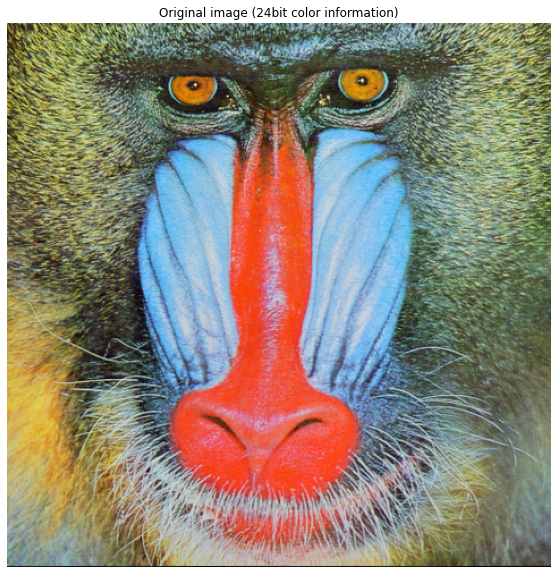

In [15]:
image = mpimg.imread('Mandrill.png')
plt.figure(1,figsize=(10,10))
plt.imshow(image)
plt.title('Original image (24bit color information)')
plt.axis('off')
plt.show()

Quantize the color information of the image. For this, we make use of the k-means algorithm from machine learning, which is essentially equivalent to the Linde-Buzo-Gray-Algorithm A. The resulting vector codebook clusters the 3d-color space into num_colors ($K$) distinct codebook entries. We then replace the image by the respective indices to the codebook.

In [25]:
def quantize_colors(image,num_colors):
    temp = np.reshape(image, (image.shape[0]*image.shape[1],3))
    
    kmeans = KMeans(n_clusters=num_colors, random_state=0, n_jobs=8, n_init=1, init='random', precompute_distances=True).fit(temp)

    #retval = kmeans.cluster_centers_[kmeans.labels_]
    #return np.reshape(retval,(image.shape[0],image.shape[1],3))
    return kmeans.cluster_centers_, kmeans.labels_

***

Convert the image to $K$ colors

In [68]:
K = 64

palette,image_q = quantize_colors(image, K)

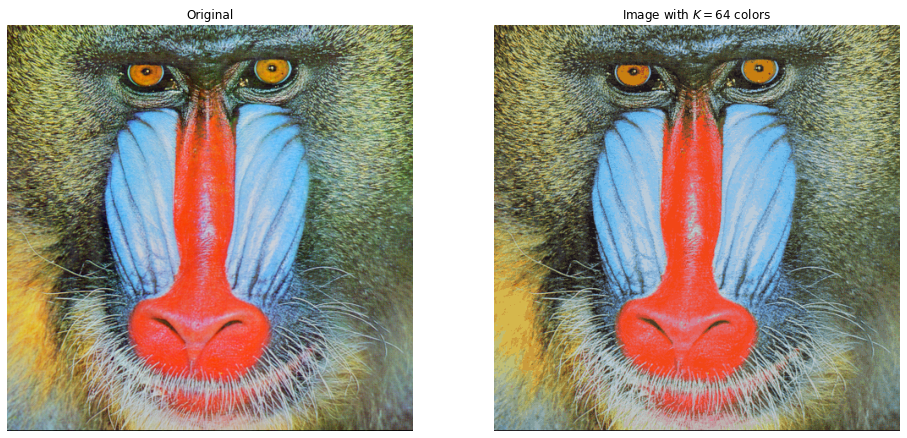

In [69]:
# generate image from indices
image_q_rec = np.reshape(palette[image_q], (image.shape[0], image.shape[1], 3))

plt.figure(1,figsize=(16,8))
plt.subplot(121)
plt.imshow(image)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_q_rec)
plt.title('Image with $K=%d$ colors' % K)
plt.axis('off')
plt.show()

Carry out LZW encoding

In [70]:
encoded,cb = LZW_encode(np.arange(K), image_q)

In [77]:
print('Color quantized image requires %d bit (%d Kybte) of storage' % (len(image_q)*8, len(image_q)/1000))

# compute storage requirements. As we grow the codebook, we always add 
storage_coded = 0
remaining_len = len(encoded)
start_bits = int(np.ceil(np.log2(K))+1)
for bits in range(start_bits, 1+int(np.ceil(np.log2(len(cb.keys()))))):
    entries = 2**bits
    if bits == start_bits:
        entries = 2**bits - 2**(bits-1)

    if remaining_len < entries:
        entries = remaining_len
        
    storage_coded += entries * bits
    remaining_len -= entries

print('Encoded image requires %d bit (%d KByte) of storage' % (storage_coded, storage_coded/8/1000))
print('Encoded image requires %d bit (%d KByte) of storage (using maximum bits per codebook entry)' % (int(np.ceil(np.log2(len(cb.keys())))) * len(encoded), int(np.ceil(np.log2(len(cb.keys())))) * len(encoded) / 8 / 1000))

Color quantized image requires 1843200 bit (230 Kybte) of storage
Encoded image requires 949424 bit (118 KByte) of storage
Encoded image requires 1145919 bit (143 KByte) of storage (using maximum bits per codebook entry)


In [78]:
# reconstruct image
decoded = LZW_decode(np.arange(K), encoded)

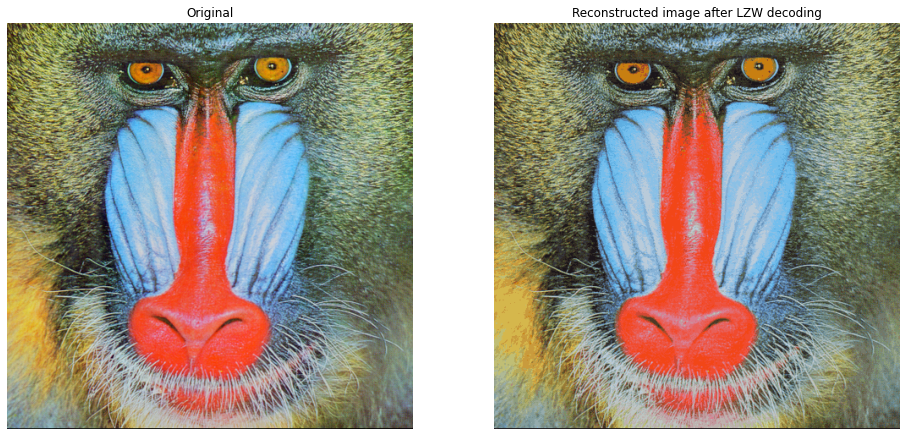

In [79]:
# generate image from indices
image_q_dec = np.reshape(palette[decoded], (image.shape[0], image.shape[1], 3))

plt.figure(1,figsize=(16,8))
plt.subplot(121)
plt.imshow(image)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_q_dec)
plt.title('Reconstructed image after LZW decoding')
plt.axis('off')
plt.show()